In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold

from catboost import CatBoostRegressor, Pool

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
train_features = pd.read_csv('data/train_features.csv', index_col=['process_id'])
test_features = pd.read_csv('data/test_features.csv', index_col=['process_id'])

train_labels = pd.read_csv('data/train_labels.csv', index_col=['process_id']).loc[train_features.index]

In [85]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))


class MAPEObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        
        
        result = []
        for index in range(len(targets)):
            y = targets[index]
            y_hat = approxes[index]
            result.append((100*(y-y_hat)/max(np.log(290000), y), 100/y))
            
        return result
        
        #grad = 2.0/approxes * (targets * 1.0 / approxes - 1)
        #hess = 2.0/(approxes**2)
        
        #return list(zip(grad, hess))
    
class MAPEMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        return custom_mape(np.exp(approxes), np.exp(targets)), len(targets)

In [ ]:
kf = KFold(n_splits=5)
for fold_nr, (train_idx, test_idx) in enumerate(kf.split(train_features, train_labels)):
    X_train = train_features.iloc[train_idx, :]
    X_test = train_features.iloc[test_idx, :]
    
    y_train = np.log(train_labels.iloc[train_idx])
    y_test = np.log(train_labels.iloc[test_idx])
    
    train_idx = np.random.choice(X_train.index, replace=False, size=int(0.9 * len(X_train)))
    val_idx = list(set(X_train.index) - set(train_idx))

    X_val = X_train.loc[val_idx, :]
    y_val = y_train.loc[val_idx]
    X_train = X_train.loc[train_idx, :]
    y_train = y_train.loc[train_idx]
    
    print('[Fold #{}] train: {}  val: {}  test: {}'.format(
        fold_nr+1, X_train.shape, X_val.shape, X_test.shape
    ))
    
    cat = CatBoostRegressor(iterations=1000, od_type='Iter', od_wait=100, learning_rate=0.33,
                            loss_function='MAPE', eval_metric=MAPEMetric())
    cat.fit(Pool(X_train, y_train), eval_set=[Pool(X_val, y_val)], logging_level='Verbose')
    
    predictions = cat.predict(X_test)
    
    print('CUSTOM MAPE = {}'.format(custom_mape(np.exp(predictions), np.exp(y_test.values.ravel()))))
    
    input()

In [86]:
X_train = train_features
y_train = np.log(train_labels)

X_test = test_features
    
train_idx = np.random.choice(X_train.index, replace=False, size=int(0.9 * len(X_train)))
val_idx = list(set(X_train.index) - set(train_idx))

X_val = X_train.loc[val_idx, :]
y_val = y_train.loc[val_idx]
X_train = X_train.loc[train_idx, :]
y_train = y_train.loc[train_idx]

print(X_train.shape, X_val.shape, X_test.shape)

cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, learning_rate=0.1,
                        loss_function='MAPE', eval_metric=MAPEMetric())
cat.fit(Pool(X_train, y_train), eval_set=[Pool(X_val, y_val)], logging_level='Verbose')
predictions = np.exp(cat.predict(X_test))

predictions_df = pd.DataFrame(predictions, columns=['final_rinse_total_turbidity_liter'])
predictions_df.index = X_test.index
predictions_df.index.name = X_test.index.name
predictions_df.to_csv('baseline.csv')
#4403:	learn: 0.2350525	test: 0.3052975	best: 0.3050983 (4303)	total: 10m 48s	remaining: 3h 54m 40s

(4504, 255) (501, 255) (2967, 255)


Got unsafe target value = 1.03762e+06 at object #2 of dataset learn
Got unsafe target value = 3.16915e+06 at object #3 of dataset test #0


0:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (0)	total: 191ms	remaining: 5h 18m 58s
1:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (1)	total: 365ms	remaining: 5h 3m 55s
2:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (2)	total: 564ms	remaining: 5h 13m 34s
3:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (3)	total: 737ms	remaining: 5h 7m 3s
4:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (4)	total: 936ms	remaining: 5h 11m 57s
5:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (5)	total: 1.11s	remaining: 5h 7m 28s
6:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (6)	total: 1.31s	remaining: 5h 11m 27s
7:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (7)	total: 1.5s	remaining: 5h 12m 40s
8:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (8)	total: 1.75s	remaining: 5h 24m 16s
9:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (9)	total: 1.97s	remaining: 5h 27m 30s
10:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (10)	total: 2.16s	remaining: 5h 27m 36s
11

89:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (89)	total: 21.1s	remaining: 6h 31m 13s
90:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (90)	total: 21.4s	remaining: 6h 31m 21s
91:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (91)	total: 21.6s	remaining: 6h 31m 40s
92:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (92)	total: 21.9s	remaining: 6h 32m 46s
93:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (93)	total: 22.2s	remaining: 6h 32m 29s
94:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (94)	total: 22.4s	remaining: 6h 32m 27s
95:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (95)	total: 22.6s	remaining: 6h 32m 30s
96:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (96)	total: 22.9s	remaining: 6h 32m 33s
97:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (97)	total: 23.1s	remaining: 6h 32m 25s
98:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (98)	total: 23.4s	remaining: 6h 33m 20s
99:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (99)	total: 23.8s

176:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (176)	total: 40.6s	remaining: 6h 21m 24s
177:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (177)	total: 40.7s	remaining: 6h 20m 52s
178:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (178)	total: 40.9s	remaining: 6h 20m 28s
179:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (179)	total: 41.1s	remaining: 6h 19m 58s
180:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (180)	total: 41.3s	remaining: 6h 19m 30s
181:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (181)	total: 41.5s	remaining: 6h 18m 55s
182:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (182)	total: 41.6s	remaining: 6h 18m 28s
183:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (183)	total: 41.8s	remaining: 6h 17m 55s
184:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (184)	total: 42s	remaining: 6h 17m 30s
185:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (185)	total: 42.2s	remaining: 6h 17m 41s
186:	learn: 0.8763393	test: 0.8698047	best: 0.869804

264:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (264)	total: 58.3s	remaining: 6h 5m 32s
265:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (265)	total: 58.5s	remaining: 6h 5m 26s
266:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (266)	total: 58.7s	remaining: 6h 5m 21s
267:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (267)	total: 58.9s	remaining: 6h 5m 31s
268:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (268)	total: 59.2s	remaining: 6h 5m 52s
269:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (269)	total: 59.4s	remaining: 6h 5m 57s
270:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (270)	total: 59.6s	remaining: 6h 5m 44s
271:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (271)	total: 59.9s	remaining: 6h 5m 51s
272:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (272)	total: 1m	remaining: 6h 5m 56s
273:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (273)	total: 1m	remaining: 6h 5m 44s
274:	learn: 0.8763393	test: 0.8698047	best: 0.8698047 (274)	total:

KeyboardInterrupt: 

In [81]:
import shap

shap.initjs()

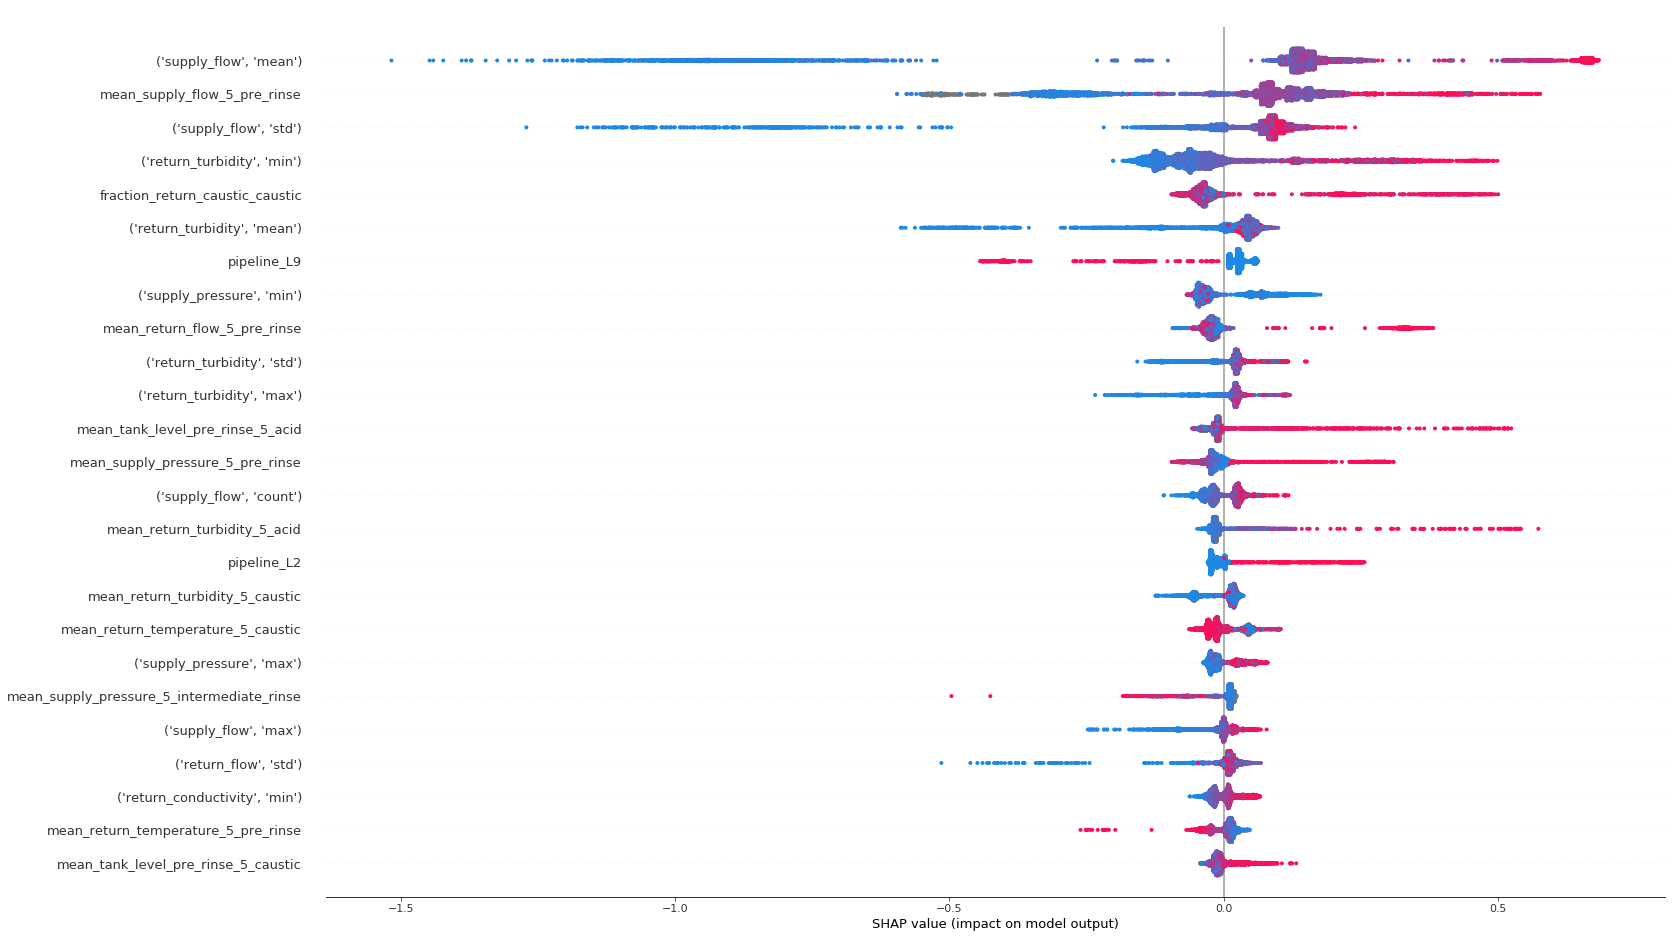

In [82]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=25, 
                  auto_size_plot=True, show=False, color_bar=False)
plt.gcf().set_size_inches(24, 16)
plt.show()